# Multivariate Weather Forecasting (Jena Climate)

Install Dependencies

In [1]:
!pip install kaggle tensorflow scikit-learn matplotlib seaborn

Upload Kaggle API

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinrajkdinesh","key":"3820967f07e7d9577c408d1c73d729a7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Download Dataset

In [4]:
!kaggle datasets download -d mnassrib/jena-climate
!unzip jena-climate.zip


Dataset URL: https://www.kaggle.com/datasets/mnassrib/jena-climate
License(s): copyright-authors
  0% 0.00/13.2M [00:00<?, ?B/s]
100% 13.2M/13.2M [00:00<00:00, 523MB/s]
Archive:  jena-climate.zip
  inflating: jena_climate_2009_2016.csv  


Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


Load Dataset

In [6]:
df = pd.read_csv("jena_climate_2009_2016.csv")

print(df.head())
print(df.shape)

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

Convert Date Column

In [7]:
df = pd.read_csv("jena_climate_2009_2016.csv") # Reload the DataFrame
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date Time', inplace=True)

Downsample to Hourly

In [8]:
df_hourly = df.resample('1H').mean()

print(df_hourly.shape)

(70129, 14)


/tmp/ipython-input-2746316402.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean()


In [20]:
df_hourly = df_hourly.dropna()


In [21]:
df_hourly = df.resample('1H').mean()

# Handle missing values
df_hourly = df_hourly.interpolate(method='time')

# Final safety check
df_hourly = df_hourly.dropna()

print("Remaining NaNs:", df_hourly.isna().sum().sum())


/tmp/ipython-input-3441290697.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean()


Remaining NaNs: 0


Target & Features

In [22]:
target_col = 'T (degC)'

features = df_hourly.columns.tolist()
print(features)

['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


Train-Test Split (Chronological)

In [24]:
train_size = int(len(df_hourly) * 0.8)

train_df = df_hourly.iloc[:train_size]
test_df = df_hourly.iloc[train_size:]


Scaling (Fit on Train Only)

In [25]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)


Sliding Window Creation

In [26]:
WINDOW_SIZE = 72

def create_sequences(data, window_size, target_index):
    X, y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, target_index])

    return np.array(X), np.array(y)

target_index = features.index(target_col)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE, target_index)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE, target_index)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (56031, 72, 14)
y_train shape: (56031,)


Model Architecture

In [27]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 72, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,737 (487.25 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 0 (0.00 B)

Callbacks

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)


Train

In [30]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0143 - val_loss: 6.2821e-04 - learning_rate: 0.0010
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0010 - val_loss: 3.2694e-04 - learning_rate: 0.0010
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 5.1621e-04 - val_loss: 2.2120e-04 - learning_rate: 0.0010
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 3.9986e-04 - val_loss: 1.5073e-04 - learning_rate: 0.0010
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 3.3944e-04 - val_loss: 1.9172e-04 - learning_rate: 0.0010
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.7613e-04 - val_loss: 2.0229e-04 - learning_rate: 0.0010
Epoch 7/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 2.3369e-04 - val_loss: 1.7542e-04 - learning_rate: 5.0000e-04
Epoch 8/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.2846e-04 - val_loss: 2.0897e-04 - learning_rate: 5.0000e-04
Epoch 9/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms

Predict

In [31]:
predictions = model.predict(X_test)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Inverse Scaling

In [32]:
temp_min = scaler.data_min_[target_index]
temp_max = scaler.data_max_[target_index]

y_test_actual = y_test * (temp_max - temp_min) + temp_min
pred_actual = predictions.flatten() * (temp_max - temp_min) + temp_min


Evaluation

In [33]:
rmse = np.sqrt(mean_squared_error(y_test_actual, pred_actual))
mae = mean_absolute_error(y_test_actual, pred_actual)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 0.8918292565073154
MAE: 0.6766142957552634


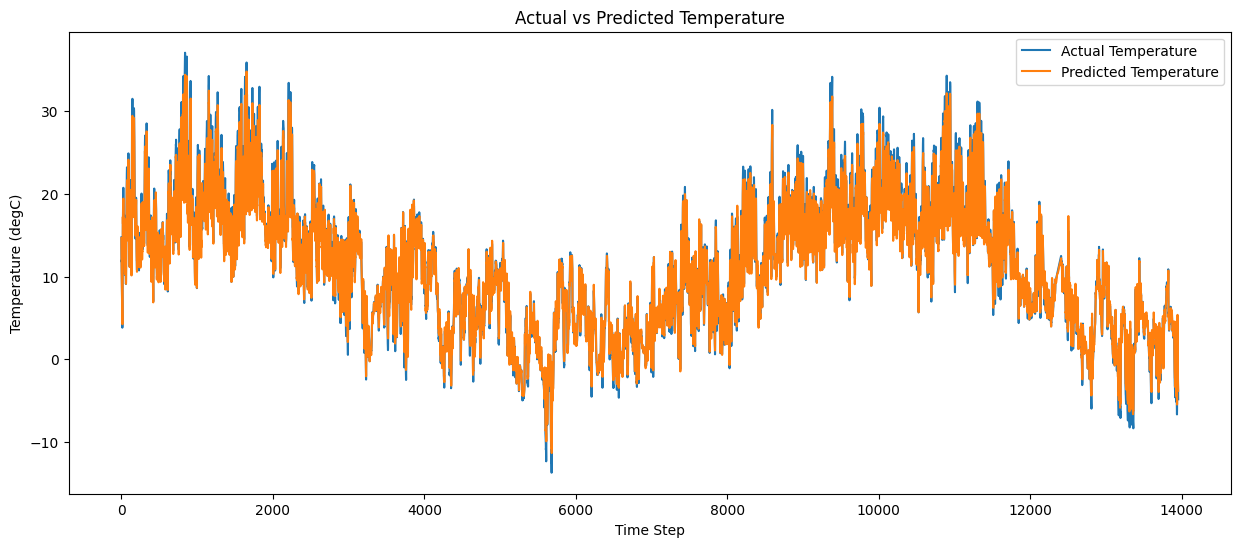

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Temperature')
plt.plot(pred_actual, label='Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

Save Model

In [34]:
model.save("weather_lstm_model.h5")

In [35]:
from google.colab import files
files.download("weather_lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test Sample Forecast

In [36]:
last_window = test_scaled[-WINDOW_SIZE:]
X_sample = np.array([last_window])

next_temp_scaled = model.predict(X_sample)
next_temp = next_temp_scaled[0][0] * (temp_max - temp_min) + temp_min

print("Predicted next-hour temperature:", next_temp)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted next-hour temperature: -4.532359553972881


Predict Next 7 Days

In [40]:
# Number of hours to forecast
FORECAST_HOURS = 48  # 7 days

# Get last window from full dataset
last_window = test_scaled[-WINDOW_SIZE:].copy()

future_predictions_scaled = []

current_window = last_window.copy()

for _ in range(FORECAST_HOURS):

    # Predict next temperature (scaled)
    pred_scaled = model.predict(np.array([current_window]), verbose=0)[0][0]

    # Store prediction
    future_predictions_scaled.append(pred_scaled)

    # Create next input row
    next_row = current_window[-1].copy()

    # Replace temperature value with predicted value
    next_row[target_index] = pred_scaled

    # Update window
    current_window = np.vstack((current_window[1:], next_row))

# Convert to numpy
future_predictions_scaled = np.array(future_predictions_scaled)


Inverse Scale to Actual Temperature

In [41]:
temp_min = scaler.data_min_[target_index]
temp_max = scaler.data_max_[target_index]

future_predictions = future_predictions_scaled * (temp_max - temp_min) + temp_min

print("Next 7 days (hourly) temperature forecast:")
print(future_predictions[:24])  # First day preview


Next 7 days (hourly) temperature forecast:
[-4.53235955 -4.73510897 -4.51099853 -4.13599464 -3.81004134 -3.59597682
 -3.47902868 -3.40338776 -3.35487812 -3.33332637 -3.34622621 -3.40439339
 -3.50935024 -3.64183367 -3.78791742 -3.93552349 -4.07426266 -4.19698799
 -4.29858117 -4.38045007 -4.44583527 -4.48463361 -4.49742249 -4.48460934]


Plot Next Week Forecast

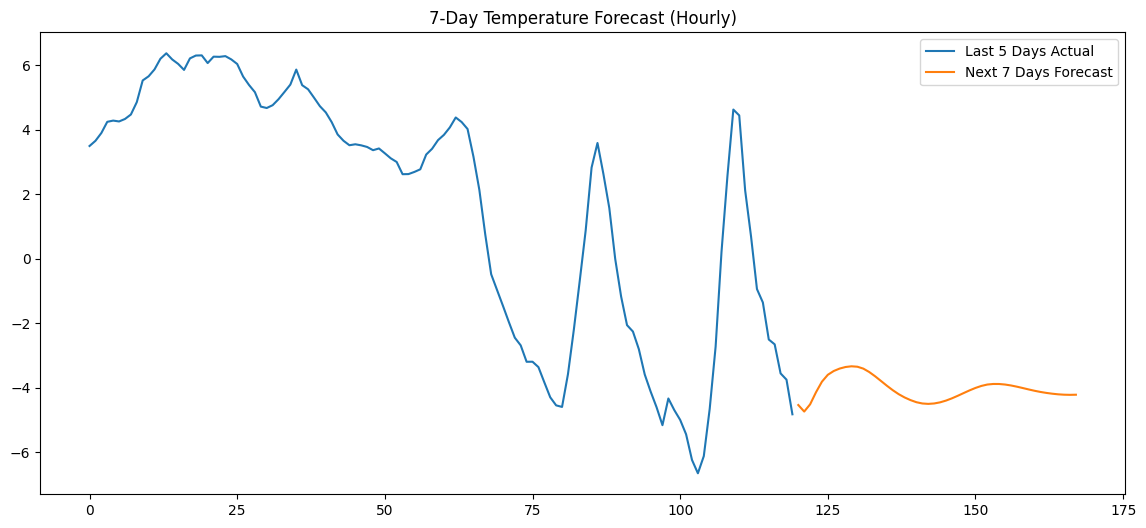

In [42]:
plt.figure(figsize=(14,6))

# Plot last 5 days historical
historical_hours = 120
plt.plot(
    df_hourly[target_col].iloc[-historical_hours:].values,
    label="Last 5 Days Actual"
)

# Plot forecast
future_index = range(historical_hours, historical_hours + FORECAST_HOURS)

plt.plot(
    future_index,
    future_predictions,
    label="Next 7 Days Forecast"
)

plt.legend()
plt.title("7-Day Temperature Forecast (Hourly)")
plt.show()


# multivariate dynamic forecasting system

Modify Sequence Creation

In [44]:
WINDOW_SIZE = 72

def create_sequences_multi(data, window_size):
    X, y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])   # full feature vector

    return np.array(X), np.array(y)

X_train, y_train = create_sequences_multi(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences_multi(test_scaled, WINDOW_SIZE)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (56031, 72, 14)
y_train: (56031, 14)


Build Multi-Output LSTM

In [46]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(len(features))   # predict ALL features
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 72, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,694 (498.80 KB)

 Trainable params: 127,694 (498.80 KB)

 Non-trainable params: 0 (0.00 B)

Train

In [47]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0180 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0030 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0023 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0021 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0020 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0020 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate:

Evaluate Temperature Only

In [48]:
predictions = model.predict(X_test)

# Inverse scaling entire feature vector
pred_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

temp_idx = features.index('T (degC)')

rmse = np.sqrt(mean_squared_error(
    y_test_actual[:, temp_idx],
    pred_actual[:, temp_idx]
))

mae = mean_absolute_error(
    y_test_actual[:, temp_idx],
    pred_actual[:, temp_idx]
)

print("Temperature RMSE:", rmse)
print("Temperature MAE:", mae)


437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Temperature RMSE: 0.7719267316564017
Temperature MAE: 0.48137189595420765


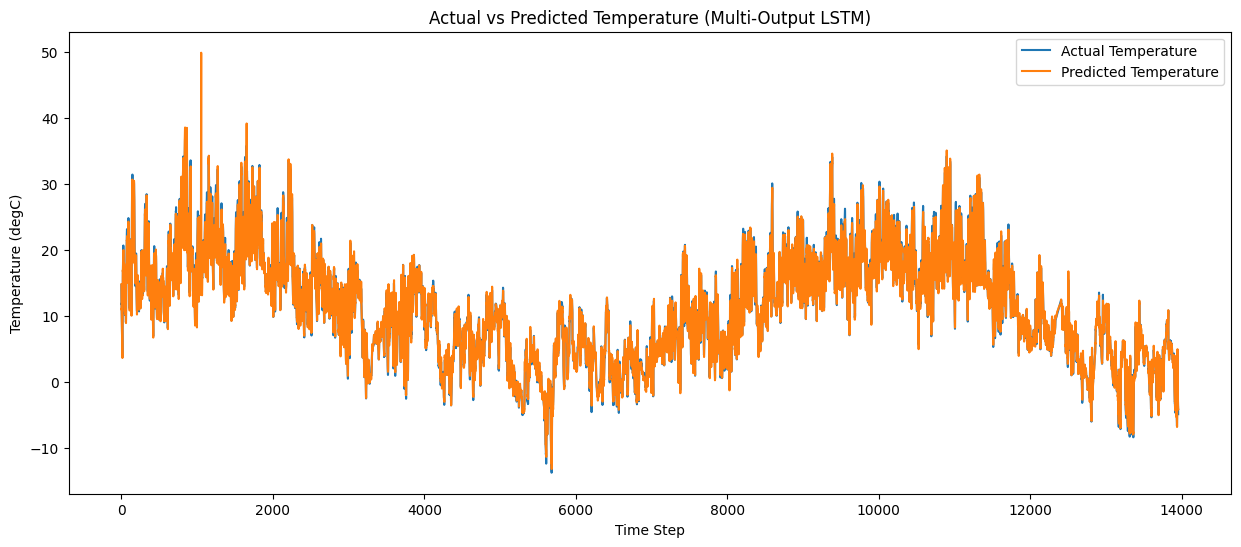

In [53]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:, temp_idx], label='Actual Temperature')
plt.plot(pred_actual[:, temp_idx], label='Predicted Temperature')
plt.title('Actual vs Predicted Temperature (Multi-Output LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()

7-Day Recursive Forecast

In [49]:
FORECAST_HOURS = 168

last_window = test_scaled[-WINDOW_SIZE:].copy()

future_predictions_scaled = []
current_window = last_window.copy()

for _ in range(FORECAST_HOURS):

    pred_scaled = model.predict(
        np.array([current_window]),
        verbose=0
    )[0]

    future_predictions_scaled.append(pred_scaled)

    current_window = np.vstack((current_window[1:], pred_scaled))

future_predictions_scaled = np.array(future_predictions_scaled)


Inverse Scale Full Forecast

In [50]:
future_predictions = scaler.inverse_transform(future_predictions_scaled)

future_temp = future_predictions[:, temp_idx]


Plot Stable Forecast

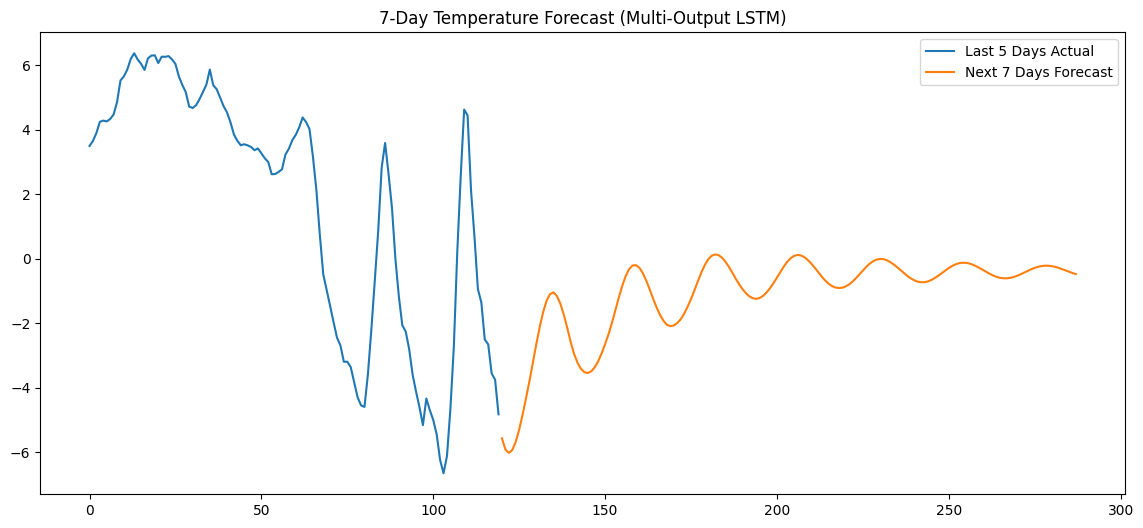

In [51]:
plt.figure(figsize=(14,6))

historical_hours = 120

plt.plot(
    df_hourly['T (degC)'].iloc[-historical_hours:].values,
    label="Last 5 Days Actual"
)

future_index = range(historical_hours, historical_hours + FORECAST_HOURS)

plt.plot(
    future_index,
    future_temp,
    label="Next 7 Days Forecast"
)

plt.legend()
plt.title("7-Day Temperature Forecast (Multi-Output LSTM)")
plt.show()


In [52]:
#download the model
model.save('multivariate_dynamic.h5')

In [54]:
from google.colab import files
files.download("multivariate_dynamic.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>